In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline


import os
print(os.listdir("../input/digit-recognizer/"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv')

In [3]:
X = train_data.iloc[:, 1:].values / 255
y = train_data.iloc[:, 0].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.15)

In [4]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((35700, 784), (35700,), (6300, 784), (6300,))

In [5]:
## train
torch_Xtrain = torch.from_numpy(Xtrain).type(torch.FloatTensor)
torch_Xtrain = torch_Xtrain.view(-1, 1, 28, 28) # creating 28 by 28 images
torch_ytrain = torch.from_numpy(ytrain).type(torch.LongTensor)
# test
torch_Xtest = torch.from_numpy(Xtest).type(torch.FloatTensor)
torch_Xtest = torch_Xtest.view(-1, 1, 28, 28)
torch_ytest = torch.from_numpy(ytest).type(torch.LongTensor)

# datasets
train_set = torch.utils.data.TensorDataset(torch_Xtrain, torch_ytrain)
test_set = torch.utils.data.TensorDataset(torch_Xtest, torch_ytest)

# dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [6]:
images, labels = next(iter(train_loader))

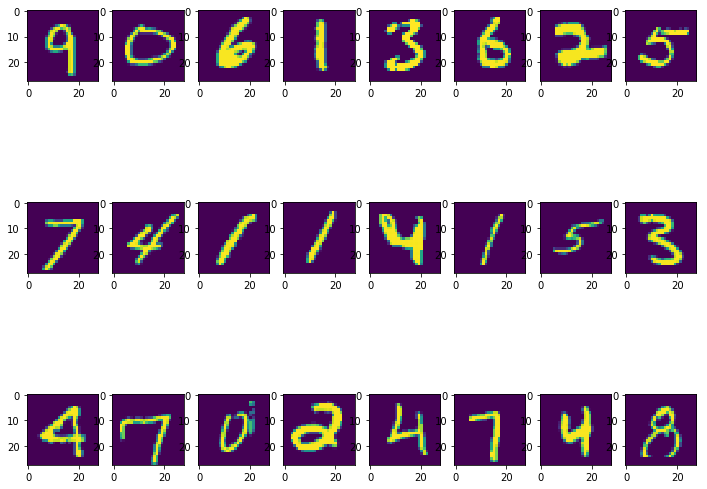

In [7]:
fig = plt.figure(figsize=(12, 10))
x, y = 8 ,3
for i in range(24):
    plt.subplot(y, x, i+1)
    plt.imshow(images[i].reshape(28, 28))
plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(128*1*1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(p=.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        # flattening
        #print(x.shape) #check shape before flattening
        x = x.view(-1,128*1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [9]:
model = Net()
model

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [11]:
epochs = 30
model.train()
for epoch in range(epochs):
    running_loss = 0
    accuracy = 0
    for step, (x_b, y_b) in enumerate(train_loader):
        X_batch = Variable(x_b)
        Y_batch = Variable(y_b)
        
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if step % 50 == 0:
            model.eval()
            pred = torch.max(output, 1)[1]
            accuracy += (pred == Y_batch).sum()
            print(f"Epoch: {epoch}, Train Loss: {running_loss}, Test Accuracy: {float(accuracy*100)/ float(len(train_loader))}")
            
        running_loss = 0

Epoch: 0, Train Loss: 2.3008015155792236, Test Accuracy: 0.44802867383512546
Epoch: 0, Train Loss: 2.2985939979553223, Test Accuracy: 0.8960573476702509
Epoch: 0, Train Loss: 2.304582357406616, Test Accuracy: 1.075268817204301
Epoch: 0, Train Loss: 2.29560923576355, Test Accuracy: 1.6129032258064515
Epoch: 0, Train Loss: 2.296989917755127, Test Accuracy: 2.060931899641577
Epoch: 0, Train Loss: 2.2937424182891846, Test Accuracy: 2.6881720430107525
Epoch: 0, Train Loss: 2.2985386848449707, Test Accuracy: 3.046594982078853
Epoch: 0, Train Loss: 2.2997233867645264, Test Accuracy: 3.225806451612903
Epoch: 0, Train Loss: 2.300339698791504, Test Accuracy: 3.315412186379928
Epoch: 0, Train Loss: 2.2871618270874023, Test Accuracy: 3.763440860215054
Epoch: 0, Train Loss: 2.2925310134887695, Test Accuracy: 4.211469534050179
Epoch: 0, Train Loss: 2.290877103805542, Test Accuracy: 4.838709677419355
Epoch: 0, Train Loss: 2.280686378479004, Test Accuracy: 5.376344086021505
Epoch: 0, Train Loss: 2.292

In [12]:
model.eval()
for images, labels in test_loader:
    #print(test_imgs.shape)
    images = Variable(images).float()
    output = model(images)
    predicted = torch.max(output,1)[1]
    accuracy += (predicted == labels).sum()
print("Test accuracy:{:.3f}% ".format(float(accuracy*100) / float(len(test_loader))))

Test accuracy:3507.614% 


# TESTING ON THE DATASET 

In [13]:
test_data = pd.read_csv('../input/digit-recognizer/test.csv')
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test_data = test_data.iloc[:, :].values / 255
test_data_torch = torch.from_numpy(test_data).type(torch.FloatTensor)
test_data_torch = test_data_torch.view(-1, 1, 28, 28)

In [15]:
test_data_torch.shape

torch.Size([28000, 1, 28, 28])

In [16]:
model.eval()
test_Images = Variable(test_data_torch).float()
output = model(test_Images)
y_pred = torch.max(output, 1)[1]

In [17]:
# checking all values are being predicted
y_pred.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
y_pred

tensor([2, 0, 9,  ..., 3, 9, 2])

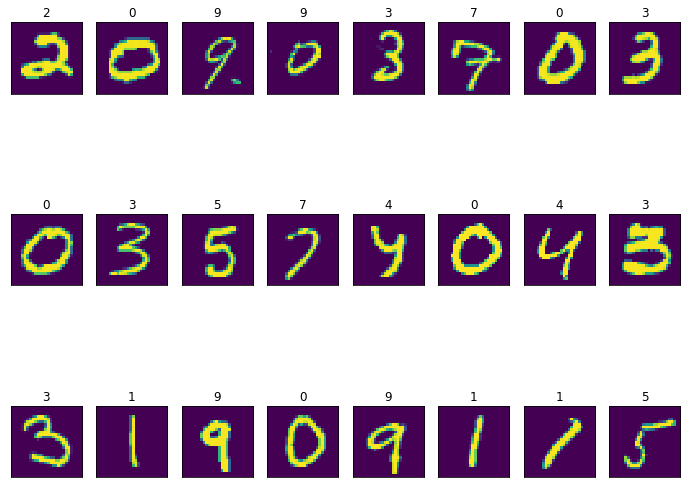

In [19]:
# visualize the predictions
fig = plt.figure(figsize=(12, 10))
x, y = 8 ,3
for i in range(24):
    ax = plt.subplot(y, x, i+1,xticks=[], yticks=[])
    ax.imshow(test_data_torch[i].reshape(28, 28))
    ax.set_title(f"{y_pred[i].item()}")

In [20]:
# saving the model
torch.save(model.state_dict(), 'pytorch_model.pt')

In [21]:
# creating the submission file
submission = pd.DataFrame({"ImageId":[i+1 for i in range(len(test_data_torch))],
                           "Label": y_pred})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [22]:
submission.to_csv("submission_with_pytorch.csv", index=False, header=True)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 